In [3]:
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install torch


     ---------------------------------------- 0.0/172.3 MB ? eta -:--:--
     --------------------------------------- 0.8/172.3 MB 24.1 MB/s eta 0:00:08
     --------------------------------------- 1.6/172.3 MB 20.5 MB/s eta 0:00:09
      -------------------------------------- 2.7/172.3 MB 21.9 MB/s eta 0:00:08
      -------------------------------------- 4.4/172.3 MB 25.5 MB/s eta 0:00:07
     - ------------------------------------- 6.7/172.3 MB 30.6 MB/s eta 0:00:06
     -- ------------------------------------ 9.6/172.3 MB 36.2 MB/s eta 0:00:05
     --- ---------------------------------- 13.7/172.3 MB 65.6 MB/s eta 0:00:03
     --- ---------------------------------- 17.7/172.3 MB 81.8 MB/s eta 0:00:02
     ---- --------------------------------- 20.7/172.3 MB 81.8 MB/s eta 0:00:02
     ----- -------------------------------- 24.4/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 28.1/172.3 MB 81.8 MB/s eta 0:00:02
     ------ ------------------------------- 31.

In [1]:
import numpy as np
import pandas as pd

import torch
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('Data/FNN_data.csv')

#subtract the columns L_0_x, L_0_y, L_0_z from all the columns
for i in range(0, 21):
    dataset[f'L_{i}_x'] = dataset[f'L_{i}_x'] - dataset['L_0_x']
    dataset[f'L_{i}_y'] = dataset[f'L_{i}_y'] - dataset['L_0_y']
    # dataset[f'L_{i}_z'] = dataset[f'L_{i}_z'] - dataset['L_0_z']
    dataset[f'R_{i}_x'] = dataset[f'R_{i}_x'] - dataset['R_0_x']
    dataset[f'R_{i}_y'] = dataset[f'R_{i}_y'] - dataset['R_0_y']
    # dataset[f'R_{i}_z'] = dataset[f'R_{i}_z'] - dataset['R_0_z']

#write datatset to csv
dataset.to_csv('Data/relative_data.csv', index=False)

X = dataset.iloc[:, 1:]
Y = dataset.iloc[:, 0]

# Splitting the dataset into the Training set and Test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

# # Feature Scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

print(X_train)
print(Y_train)


       L_0_x  L_0_y         L_0_z     L_1_x     L_1_y     L_1_z     L_2_x  \
8828     0.0    0.0  4.693281e-08  0.044768 -0.034180 -0.008184  0.079449   
7135     0.0    0.0 -1.353828e-07  0.030682 -0.050125 -0.021010  0.048441   
2437     0.0    0.0 -1.714135e-07 -0.013214 -0.051356 -0.021297 -0.036674   
6561     0.0    0.0 -1.236475e-07  0.029176 -0.058769 -0.023121  0.045614   
8611     0.0    0.0  6.750653e-08  0.041068 -0.023228 -0.008134  0.078238   
...      ...    ...           ...       ...       ...       ...       ...   
6625     0.0    0.0  7.628206e-08  0.038646 -0.065279 -0.016904  0.068201   
11535    0.0    0.0  3.251272e-07  0.036794 -0.011408 -0.025899  0.065273   
14017    0.0    0.0  2.713402e-07  0.044306 -0.013206 -0.017797  0.081429   
1255     0.0    0.0 -2.881599e-07 -0.008716 -0.059962 -0.025361 -0.023841   
2787     0.0    0.0  1.849431e-07 -0.003646 -0.074349 -0.006986  0.003260   

          L_2_y     L_2_z     L_3_x  ...    R_17_z    R_18_x    R_18_y  \
8

In [3]:
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
Y_train_tensor = torch.tensor(Y_train.values).long()
Y_test_tensor = torch.tensor(Y_test.values).long()

In [4]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)


torch.Size([14400, 126])
torch.Size([14400])


In [5]:
batch_size = 128
n_iters = 10000
num_epochs = n_iters / (len(X_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(X_train_tensor,Y_train_tensor)
test = torch.utils.data.TensorDataset(X_test_tensor,Y_test_tensor)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

In [10]:
import sys
!{sys.executable} -m pip install torchbnn


In [11]:
import torchbnn as bnn

In [26]:
class BayesianNN(torch.nn.Module):
    def __init__(self):
        super(BayesianNN, self).__init__()

        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                      in_features=126, out_features=184)
        self.sg1 = torch.nn.Sigmoid()

        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                        in_features=184, out_features=100)
        self.sg2 = torch.nn.Sigmoid()

        self.fc3 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                                        in_features=100, out_features=2)
    def forward(self, x):
        x = self.fc1(x)
        x = self.sg1(x)
        x = self.fc2(x)
        x = self.sg2(x)
        x = self.fc3(x)
        return x
        

In [27]:
model = BayesianNN()

ce_loss = torch.nn.CrossEntropyLoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.1    

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [28]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for i, (landmarks, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(landmarks)
        loss = ce_loss(outputs, labels) + kl_weight * kl_loss(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
      print("epoch = %4d   loss = %0.8f" % (epoch, epoch_loss))
    
print("Training done ")

epoch =    0   loss = 35.80709310
epoch =   10   loss = 1.99552015
epoch =   20   loss = 5.25889277
epoch =   30   loss = 2.14826788
epoch =   40   loss = 4.29612902
epoch =   50   loss = 1.92934174
epoch =   60   loss = 1.88641575
epoch =   70   loss = 1.90632917
epoch =   80   loss = 2.18885347
Training done 


In [ ]:
for step in range(3000):
    pre = model(X_train_tensor)
    ce = ce_loss(pre, Y_train_tensor)
    kl = kl_loss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

In [6]:
class GestureFNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
        super(GestureFNN, self).__init__()
        # Linear function 1: 126 --> 84
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim_1)

        # Non-linearity 1
        self.sigmoid = torch.nn.Sigmoid()

        # Linear function 2: 84 --> 2
        self.fc2 = torch.nn.Linear(hidden_dim_1, hidden_dim_2)

        self.sigmoid = torch.nn.Sigmoid()

        self.fc3 = torch.nn.Linear(hidden_dim_2, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)

        # Non-linearity 1
        out = self.sigmoid(out)

        # Linear function 2 (readout)
        out = self.fc2(out)

        out = self.sigmoid(out)

        out = self.fc3(out)
        return out



In [7]:
model = GestureFNN(input_dim=126, hidden_dim_1=256, hidden_dim_2=64, output_dim=2)

critereon = torch.nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
iter = 0
accuracy_list = []
loss_list = []
for epoch in range(num_epochs):
    for i, (landmarks, labels) in enumerate(train_loader):

        lanmarks = landmarks.view(-1, 126).requires_grad_()

        optimizer.zero_grad()

        outputs = model(landmarks)

        loss = critereon(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for landmarks, labels in test_loader:
                landmarks = landmarks.view(-1, 126).requires_grad_()

                outputs = model(landmarks)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            accuracy_list.append(accuracy)
            loss_list.append(loss.item())

            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6310913562774658. Accuracy: 51.80555725097656
Iteration: 1000. Loss: 0.024552742019295692. Accuracy: 100.0
Iteration: 1500. Loss: 0.006567307747900486. Accuracy: 100.0
Iteration: 2000. Loss: 0.004144882317632437. Accuracy: 100.0
Iteration: 2500. Loss: 0.0025570918805897236. Accuracy: 100.0
Iteration: 3000. Loss: 0.0016934155719354749. Accuracy: 100.0
Iteration: 3500. Loss: 0.0010329207871109247. Accuracy: 100.0
Iteration: 4000. Loss: 0.0007505557150579989. Accuracy: 100.0
Iteration: 4500. Loss: 0.0009740832610987127. Accuracy: 100.0
Iteration: 5000. Loss: 0.0009398242109455168. Accuracy: 100.0
Iteration: 5500. Loss: 0.0006156744202598929. Accuracy: 100.0
Iteration: 6000. Loss: 0.0005299914046190679. Accuracy: 100.0
Iteration: 6500. Loss: 0.0008740508346818388. Accuracy: 100.0
Iteration: 7000. Loss: 0.0005092008505016565. Accuracy: 100.0
Iteration: 7500. Loss: 0.0005059230024926364. Accuracy: 100.0
Iteration: 8000. Loss: 0.00029723052284680307. Accuracy: 100.0
It

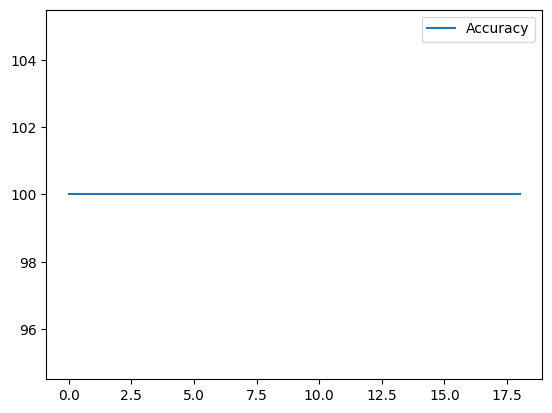

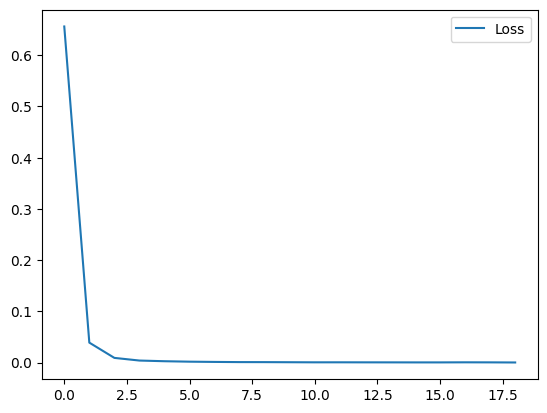

In [107]:
# plot accuracy and loss seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_style("darkgrid")
# plt.plot(loss_list, label="Loss")
plt.plot(accuracy_list, label="Accuracy")
plt.legend()
plt.show()

# plot the loss
plt.plot(loss_list, label="Loss")
plt.legend()
plt.show()


^ this is most likely overfitting

In [108]:
# save the model
torch.save(model.state_dict(), 'Model/model.pth')

In [9]:
# test the model on the test set
correct = 0
total = 0
for landmarks, labels in test_loader:
    # landmarks = landmarks.view(-1, 126).requires_grad_()

    outputs = model(landmarks)
    print(outputs)

    _, predicted = torch.max(outputs.data, 1)

    # print(predicted)

    total += labels.size(0)

    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

print('Accuracy of the model on the test set: {}'.format(accuracy))


tensor([[-6.3919,  6.2182],
        [ 5.0409, -5.0424],
        [-3.7302,  3.6017],
        [ 4.7199, -4.7261],
        [ 2.9582, -2.9915],
        [ 4.3804, -4.3925],
        [ 5.3409, -5.3374],
        [ 4.7643, -4.7690],
        [-5.0449,  4.8952],
        [ 4.0485, -4.0654],
        [-3.6685,  3.5413],
        [ 3.6075, -3.6320],
        [ 4.6863, -4.6924],
        [-4.6702,  4.5270],
        [-2.1809,  2.0754],
        [ 3.6311, -3.6545],
        [-4.8393,  4.6933],
        [ 5.4028, -5.3980],
        [-4.1376,  4.0030],
        [ 3.0887, -3.1200],
        [ 4.8673, -4.8713],
        [-7.1189,  6.9308],
        [ 4.7465, -4.7521],
        [ 4.7194, -4.7259],
        [-5.5331,  5.3755],
        [-5.5780,  5.4194],
        [ 5.4123, -5.4063],
        [-4.8742,  4.7279],
        [-5.2445,  5.0921],
        [-3.0191,  2.9018],
        [-5.1552,  5.0041],
        [-4.9197,  4.7726],
        [-3.9202,  3.7890],
        [ 5.2399, -5.2373],
        [ 5.2311, -5.2294],
        [ 2.7010, -2

In [33]:
import sys
!{sys.executable} -m pip install seaborn

     ---------------------------------------- 0.0/293.3 kB ? eta -:--:--
     -------------------------------------  286.7/293.3 kB 8.9 MB/s eta 0:00:01
     -------------------------------------- 293.3/293.3 kB 6.0 MB/s eta 0:00:00


[[ 6  0]
 [ 0 10]]


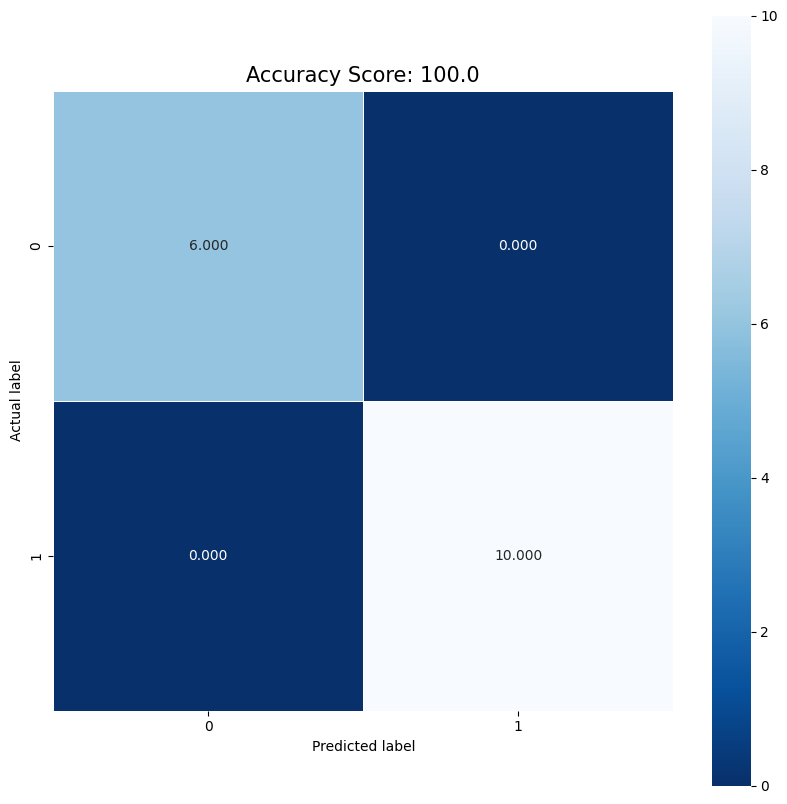

In [110]:
# plot a graphical confusion matrix for the test set using matplotlib
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels, predicted)
print(cm)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy)
plt.title(all_sample_title, size=15)
plt.show()

